In [11]:
import numpy as np 
import pandas as pd
import seaborn as sns

In [12]:
df = pd.read_csv('merged.csv')

In [13]:
df = df.drop(columns='Unnamed: 0')

In [14]:
import pandas as pd
df['scheduled'] = pd.to_datetime(df['scheduled'])
df['actual'] = pd.to_datetime(df['actual'])
df['No. of late arrivals'] = (df['actual'] > df['scheduled'])
route_ranking = df.groupby('route_id')['No. of late arrivals'].mean().reset_index()
route_ranking = route_ranking.sort_values(by='No. of late arrivals')


In [15]:
df['time_point_order'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [16]:
route_ranking =route_ranking.reset_index()

In [17]:
route_ranking = route_ranking.drop(columns='index')

<AxesSubplot: >

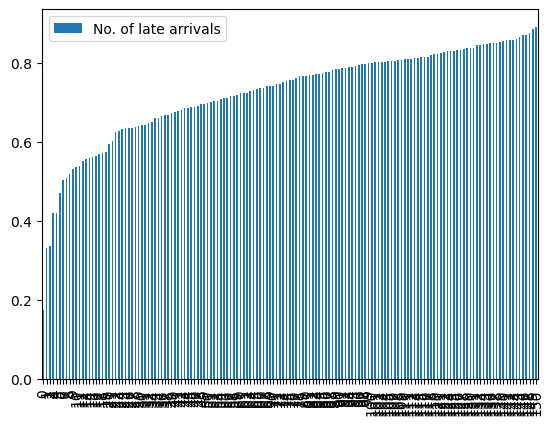

In [18]:
route_ranking.plot(kind='bar')

<AxesSubplot: >

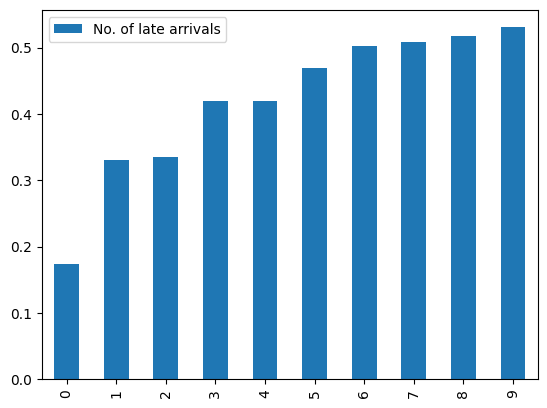

In [19]:
route_ranking.iloc[:10].plot(kind='bar')

In [20]:
df.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,No. of late arrivals
0,2023-01-01,01,Inbound,58061899.0,110,hhgat,1,Startpoint,Schedule,1900-01-01 06:05:00+00:00,1900-01-01 06:05:04+00:00,NaN,NaN,True
1,2023-01-01,01,Inbound,58061899.0,67,maput,2,Midpoint,Schedule,1900-01-01 06:09:00+00:00,1900-01-01 06:06:28+00:00,NaN,NaN,False
2,2023-01-01,01,Inbound,58061899.0,72,cntsq,3,Midpoint,Schedule,1900-01-01 06:12:00+00:00,1900-01-01 06:08:57+00:00,NaN,NaN,False
3,2023-01-01,01,Inbound,58061899.0,75,mit,4,Midpoint,Schedule,1900-01-01 06:15:00+00:00,1900-01-01 06:12:41+00:00,NaN,NaN,False
4,2023-01-01,01,Inbound,58061899.0,79,hynes,5,Midpoint,Schedule,1900-01-01 06:19:00+00:00,1900-01-01 06:16:35+00:00,NaN,NaN,False
